# Overview



In the last notebook, we saw a simple example of using cycontext to extract contextual information about a clinical entity. In this notebook we'll show how to integrate cycontext into a spaCy pipeline for scalable clinical text processing.

In [1]:
import spacy
from spacy.pipeline import EntityRuler

from cycontext import ConTextComponent, ConTextItem

# spaCy Pipelines
A spaCy model process texts through a sequential process called a "pipeline". Each part of a pipeline is called a **component** and handles a different part of text processing. This allows our models to be modular and flexible. 

By default, a processing pipeline looks like this:

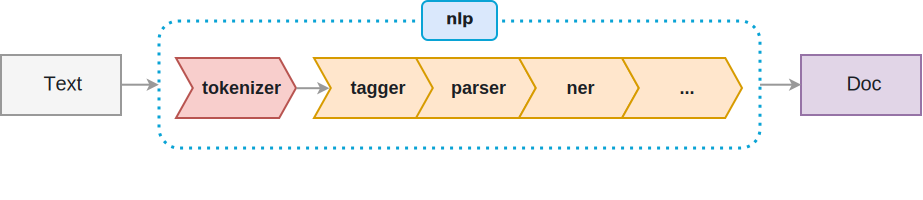

In [2]:
from IPython.display import SVG
SVG("./spacy_pipeline.svg")

One of the most powerful features of spaCy is that we can customize a pipeline to define our own processing on a text. `cycontext` is designed to be used as a spaCy component and to fit within a processing pipeline. In this notebook, we'll walk through how to add ConText to a pipeline for processing multiple clinical documents. In this notebook, we'll define several texts with multiple targets and modifiers.

In [3]:
texts = [
    "There is no evidence of pneumonia.",
    "rule out pna",
    "HISTORY OF PE.",
]

# Load Model
We start by loading a standard spaCy model which comes with a standard processing pipeline. However, we'll remove the standard `ner` model since we'll be defining our own entity classes.

In [4]:
nlp = spacy.load("en_core_web_sm", disable="ner")

In [5]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x10faa3f98>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x10fc417c8>)]

# Target Concept Extraction
As cycontext is modular, it does not handle extracting target concepts. These concepts should be extracted earlier in a spaCy pipeline and stored in `doc.ents`. There are various methods for extracting these target concepts. One way is through [rule-based matching](https://spacy.io/usage/rule-based-matching), such as spaCy's `EntityRuler` class. 

The sentences above have the following target entities:
- "pneumonia"
- "pna"
- "PE"

We instantiate an EntityRuler class and then define patterns to match these concepts in the texts. In the spaCy API, we do this by defining a list of dictionaries which define the label and pattern for each concept. 

For more detailed information, see spaCy's documentation on rule-based matching: https://spacy.io/usage/rule-based-matching. 

In this example, we'll assign a label of **"CONDITION"** to each entity.

In [6]:
ruler = EntityRuler(nlp, overwrite_ents=True, phrase_matcher_attr="LOWER")

In [7]:
target_patterns = [
    {
        'label': 'CONDITION',
        'pattern': "pneumonia"
    },
    {
        'label': 'CONDITION',
        'pattern': "pna"
    },
    {
        'label': 'CONDITION',
        'pattern': "PE"
    },
]

We then add these to the ruler:

In [8]:
ruler.add_patterns(target_patterns)

And then add this to our pipeline:

In [9]:
nlp.add_pipe(ruler, last=True)

In [10]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x10faa3f98>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x10fc417c8>),
 ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler at 0x10f9b5c88>)]

We can now process each of the texts and find our extracted targets in the `ents` attribute. We process a list of texts by calling `list(nlp.pipe(texts))`:

In [11]:
docs = list(nlp.pipe(texts))

In [12]:
for doc in docs:
    print(doc.ents)

(pneumonia,)
(pna,)
(PE,)


# ConText
Once we have extracted target concepts in our pipeline, we define the modifiers. In these examples, there are 3 modifiers to be extracted:
- **"no evidence of"**: this signifies negation. We call this **DEFINITE_NEGATED_EXISTENCE**
- **"rule out"**: this signifies that the purpose of an exam is to check whether a patient has a condition. We call this **INDICATION**
- **"PMH"**: this signifies "past medical history" and that a condition is not current. We call this "HISTORICAL"

We define these and store them in a list of ConTextItems:

We then instantiate our ConTextComponent with the default rules:

In [13]:
context = ConTextComponent(nlp, rules="default")

In [14]:
# item_data = [
#     ConTextItem("no evidence of", category="DEFINITE_NEGATED_EXISTENCE", rule="forward"),
#     ConTextItem("rule out", category="INDICATION", rule="forward"),
#     ConTextItem("Past Medical History", category="HISTORICAL", rule="forward")
# ]

In [15]:
# context.add(item_data)

In [16]:
context.categories

{'FAMILY',
 'HISTORICAL',
 'HYPOTHETICAL',
 'NEGATED_EXISTENCE',
 'POSSIBLE_EXISTENCE'}

In the last notebook, we called context directly on a doc: `context(doc)`. We'll now instead add it to the NLP pipeline so it will process each of the documents. Because it follows target concept extraction, we can specify its place in a pipeline by setting the `after` argument to `"entity_ruler"`:

In [ ]:
nlp.add_pipe(context, after="entity_ruler")

In [ ]:
nlp.pipeline

Now when we process our texts we can see the ConText information which we extracted manually in the previous notebook.

In [ ]:
docs = list(nlp.pipe(texts))

In [ ]:
for doc in docs:
    for target, modifier in doc._.context_graph.edges:
        print("[{0}] is modified by [{1}]".format(target, modifier))
    print()

When using the visualization module, colors can be optionally supplied to the `colors` argument of `visualize_ent`. If left to `None`, a color cycle will be generated using the default matplotlib colors. However, we can also define them manually:

In [ ]:
from cycontext import viz
colors = {"NEGATED_EXISTENCE": "#34b1eb",
                          "POSSIBLE_EXISTENCE": "yellow",
                           "HISTORICAL": "#ddb8f5",
                          "CONDITION": "orange"}

In [ ]:
viz.visualize_ent(docs[0], 
                  colors=colors
                 )

In [ ]:
viz.visualize_ent(docs[1], 
                  colors=colors
                 )

In [ ]:
from cycontext import viz
viz.visualize_ent(docs[2], 
                  colors=colors,
                 )

In [ ]:
viz.visualize_dep(docs[2])